In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel('Precios Mandarina Oneco.xlsx', index_col=0)
df.drop(["Volumen Producción mandarina antioquia anual"], axis = 1, inplace = True)
df.index.freq='MS' # le digo al programa que la frecuencia es mensual
df.dtypes



Promedio de precio mensual mayorista    int64
dtype: object

In [4]:
# Defino Variables

df.rename(columns = {'Promedio de precio mensual mayorista': 'precio_COP'}, inplace = True)
df.head()

,precio_COP
Fecha,
2017-01-01,2500
2017-02-01,3375
2017-03-01,3075
2017-04-01,2650
2017-05-01,2450


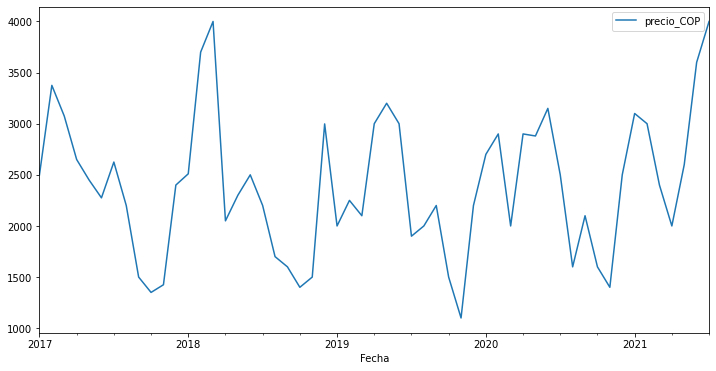

In [5]:
df.plot(figsize=(12,6))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


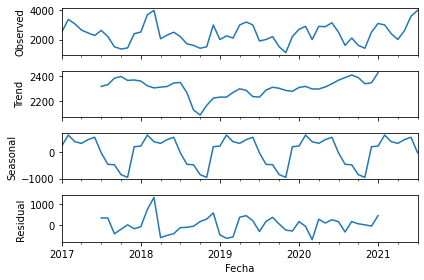

In [7]:
results = seasonal_decompose(df['precio_COP'])
results.plot();

No vamos a convertir la serie en no estacionaria porque teoricamente las predicciones de RNN se pueden adaptar a este patrón

In [8]:
len(df)

55

In [9]:
train = df.iloc[:45]
test =df.iloc[45:]

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Con esta herramienta, convertimos la serie en una escala de 0 a 1

In [11]:
df.head(),df.tail()

(            precio_COP
 Fecha                 
 2017-01-01        2500
 2017-02-01        3375
 2017-03-01        3075
 2017-04-01        2650
 2017-05-01        2450,             precio_COP
 Fecha                 
 2021-03-01        2400
 2021-04-01        2000
 2021-05-01        2600
 2021-06-01        3600
 2021-07-01        4000)

In [12]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
scaled_train[:10]

array([[0.48275862],
       [0.78448276],
       [0.68103448],
       [0.53448276],
       [0.46551724],
       [0.40517241],
       [0.52586207],
       [0.37931034],
       [0.13793103],
       [0.0862069 ]])

In [13]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [18]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.48275862 0.78448276 0.68103448]
Predict this y: 
 [[0.53448276]]


In [19]:
X.shape

(1, 3, 1)

In [20]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [21]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [22]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
33/33 [==============================] - 2s 7ms/step - loss: 0.0846
Epoch 2/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0589
Epoch 3/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0657
Epoch 4/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0641
Epoch 5/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0625
Epoch 6/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0589
Epoch 7/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0606
Epoch 8/50
33/33 [==============================] - 0s 8ms/step - loss: 0.0623
Epoch 9/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0555
Epoch 10/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0595
Epoch 11/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0519
Epoch 12/50
33/33 [==============================] - 0s 6ms/step - loss: 0.0567
Epoch 13/50
33/33 [==============================

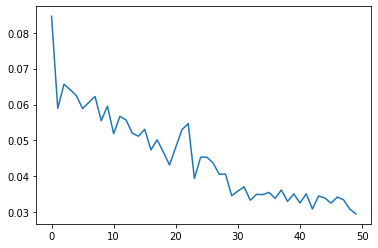

In [25]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [26]:
last_train_batch = scaled_train[-12:]

In [27]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [28]:
model.predict(last_train_batch)

array([[0.1854057]], dtype=float32)

In [29]:
scaled_test[0]

array([0.17241379])

In [30]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [31]:
test_predictions

[array([0.1854057], dtype=float32),
 array([0.20972972], dtype=float32),
 array([0.47117823], dtype=float32),
 array([0.5658998], dtype=float32),
 array([0.60811335], dtype=float32),
 array([0.54211104], dtype=float32),
 array([0.6498868], dtype=float32),
 array([0.64606965], dtype=float32),
 array([0.6271787], dtype=float32),
 array([0.4840301], dtype=float32)]

In [32]:
test.head()

,precio_COP
Fecha,
2020-10-01,1600
2020-11-01,1400
2020-12-01,2500
2021-01-01,3100
2021-02-01,3000


In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

In [34]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


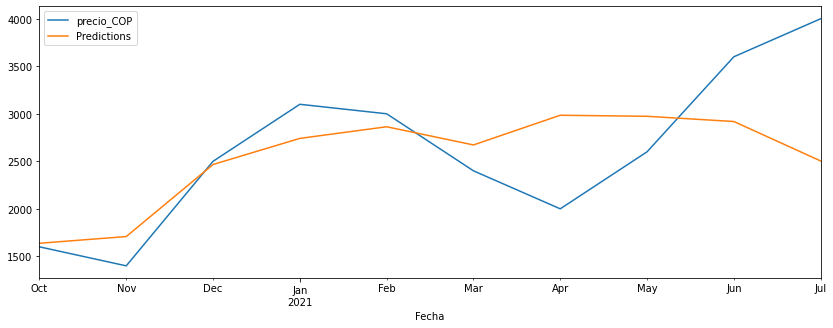

In [39]:
test.plot(figsize=(14,5))

In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['precio_COP'],test['Predictions']))
print(rmse)

642.7393581647365
